# CNN autoencoder

In [1]:
# NOTE: this is a custom cell that contains the common imports I personally 
# use these may/may not be necessary for the following examples

# DL framework
import tensorflow as tf

from datetime import datetime

# common packages
import numpy as np
import os # handling file i/o
import sys
import math
import time # timing epochs

# for ordered dict when building layer components
import collections

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import colors # making colors consistent
from mpl_toolkits.axes_grid1 import make_axes_locatable # colorbar helper

# read image
from imageio import imread
# + data augmentation
from scipy import ndimage
from scipy import misc

# used for manually saving best params
import pickle

# for shuffling data batches
from sklearn.utils import shuffle

# const
SEED = 42

# Helper to make the output consistent
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# helper to create dirs if they don't already exist
def maybe_create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("{} created".format(dir_path))
    else:
        print("{} already exists".format(dir_path))
    
# set tf log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Important Version information
print("Python: {}".format(sys.version_info[:]))
print('TensorFlow: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

Python: (3, 5, 4, 'final', 0)
TensorFlow: 1.6.0-dev20180105
No GPU found


In [7]:
# `saver/` will hold tf saver files
maybe_create_dir("saver")
# `best_params/` will hold a serialized version of the best params
# I like to keep this as a backup in case I run into issues with
# the saver files
maybe_create_dir("best_params")

saver createed
best_params createed


In [4]:
ROOT_DATA = "../../../ROOT_DATA/"
DATA_DIR = "mnist_data"

MNIST_TRAINING_PATH = os.path.join(ROOT_DATA, DATA_DIR)
maybe_create_dir(MNIST_TRAINING_PATH)

../../../ROOT_DATA/mnist_data already exists


In [5]:
# import dataset (should already be present)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(MNIST_TRAINING_PATH, validation_size=0)

Extracting ../../../ROOT_DATA/mnist_data/train-images-idx3-ubyte.gz
Extracting ../../../ROOT_DATA/mnist_data/train-labels-idx1-ubyte.gz
Extracting ../../../ROOT_DATA/mnist_data/t10k-images-idx3-ubyte.gz
Extracting ../../../ROOT_DATA/mnist_data/t10k-labels-idx1-ubyte.gz


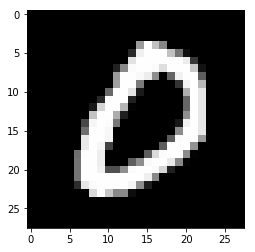

In [6]:
# ------ Make sure we're up and running
# display, random, single image
img = mnist.train.images[np.random.randint(6000, size=1)]

# mnist is 28x28 = 784 and is grayscale
# meaning, the 784 vector needs to be reshaped to 28,28
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [8]:
reset_graph()
encoding_dim = 64
learning_rate = 0.001
img_vect_size = mnist.train.images.shape[1]

# input place holders
input_vector = tf.placeholder(tf.float32, (None, img_vect_size), name="input_vector")
vect_reshape = tf.reshape(input_vector, [-1, 28, 28, 1])
input_target = tf.placeholder(tf.float32, (None, img_vect_size), name="input_label")
target_reshape = tf.reshape(input_target, [-1, 28, 28, 1])

# --- Model
### Encoder
conv2 = tf.layers.conv2d(inputs=vect_reshape, filters=16, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 14x14x16

encoded = tf.layers.conv2d(inputs=conv2, filters=32, 
                         kernel_size=(3,3), strides=2, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         bias_initializer=tf.zeros_initializer(),
                         padding='same', 
                         activation=tf.nn.elu)
# Now 7x7x32

dconv1 = tf.layers.conv2d_transpose(inputs=encoded, filters=16, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=tf.nn.elu)
# Now 14x14x64

logits = tf.layers.conv2d_transpose(inputs=dconv1, filters=1, 
                                    kernel_size=(3,3), strides=2, 
                                    padding="same", activation=None)

#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

# loss
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=target_reshape, logits=logits)
batch_loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                               beta1=0.9,
                                               beta2=0.999,
                                               epsilon=1e-08,
                                               use_locking=False,
                                               name='Adam')
training_op = optimizer.minimize(batch_loss)

# initializer and saver
with tf.name_scope("save_session"):
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    saver = tf.train.Saver()
    
print("ready")

ready


In [9]:
epochs = 1
batch_size = 64
train_size = mnist.train.num_examples

with tf.Session() as sess:
    init_global.run()
    init_local.run()
    for e in range(epochs):
        for i in range(train_size//batch_size):
            batch_cur = mnist.train.next_batch(batch_size)
            feed_dict = {input_vector: batch_cur[0], input_target: batch_cur[0]}
            cost_batch, _ = sess.run([batch_loss, training_op], feed_dict=feed_dict)
            if i == 0:
                print("E: {}/{} - loss: {:.4f}".format(e+1, epochs, cost_batch))
    save_path = saver.save(sess, "./saver/cnn_autoencoder")

E: 1/1 - loss: 0.6943


INFO:tensorflow:Restoring parameters from ./saver/cnn_autoencoder


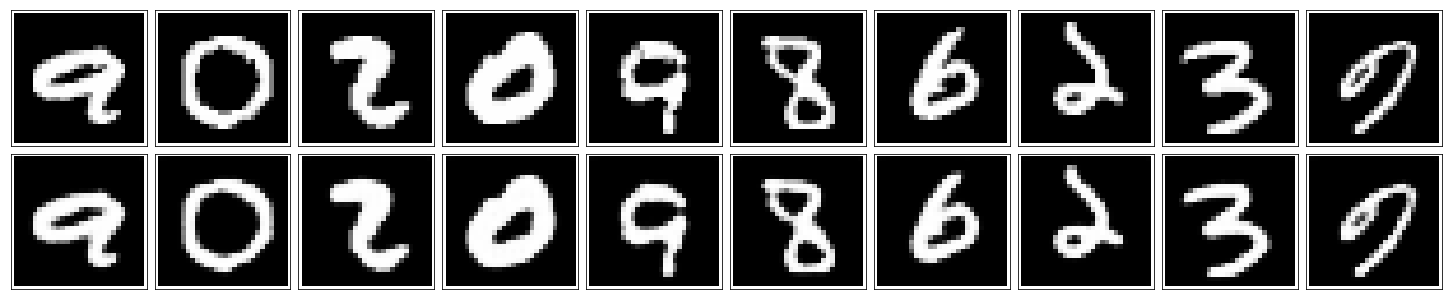

In [10]:
save_path = "./saver/cnn_autoencoder"
sess = tf.Session()
saver.restore(sess, save_path)

start_index = int(np.random.randint(6000, size=1) - 10)
in_imgs = mnist.test.images[start_index:start_index+10]

# run model
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={input_vector: in_imgs})

# plot
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)